# Video Popularity Prediction Challenge, Bitgrit

Réalisé par: 

<font style='font-family:Georgia' size='3.5'>Rida ENNAMIRI <br> Yebabah Eric Martin N'GORAN <br> Vanessa VANDENBERGHE <br> <br></font>

**Context**

DataGateway est une startup japonaise dont la mission est d'accompagner les entreprises dans leur transformation digitale en appliquant la puissance des technologies de pointe, notamment l'IA, la blockchain et l'informatique décentralisée. L'un des clients de DataGateway est à la recherche d'un algorithme qui prédit le nombre de vues que les vidéos téléchargées sur leur plateforme sont susceptibles d'obtenir afin de pouvoir maximiser les vues. Cet algorithme aidera également l'entreprise à fixer le prix des publicités diffusées dans les vidéos sur sa plateforme.

**A propos du challenge**

L'objectif de ce concours est de développer un modèle d'apprentissage automatique pour prédire le nombre de vues que les vidéos sont susceptibles de recevoir en fonction d'attributs tels que la durée,le nombre de likes et le moment de publication.

En effet, le fait que cet algorithme est simplement une application intéressante de la science des données, les créateurs de vidéos veulent savoir comment donner à leurs vidéos les meilleures chances de devenir virales. S'ils peuvent améliorer leurs chances en publiant leur vidéo à un certain moment de la journée ou avec un certain titre, ils peuvent améliorer leurs chances d'être vus par un public plus large.
Du côté des entreprises, les plates-formes d'hébergement vidéo pourraient utiliser un tel algorithme de prédiction pour déterminer quelles vidéos ont le potentiel d'être très populaires. Cela peut aider la plateforme vidéo à fixer efficacement le prix des publicités sur ces vidéos, car elle ne voudrait pas placer des publicités coûteuses sur des vidéos que personne ne regarderait.

**Importation des librairies utiles pour ce notebook**

In [ ]:
!pip install catboost

     |████████████████████████████████| 65.7MB 56kB/s 


In [102]:
import pandas as pd
import matplotlib.pyplot as plt
from math import exp, sqrt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectFromModel

import random
import collections
import sklearn.metrics

from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression, Ridge 
from sklearn import preprocessing, svm, tree
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor 
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import tensorflow as tf

from sklearn.metrics import mean_squared_error

## Analyse des données


### Importation des jeux de données et premières analyses

Dans un premier temps, nous allons importer les jeux de données mis à disposition pour ce challenge.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importation des jeux de données d'entraînement



In [10]:
# Jeu de données "train_meta_data"
metadata = pd.read_csv('/content/drive/MyDrive/FDA/Dataset/Metadata/train_meta_df.csv')
metadata.head()

,comp_id,ad_blocked,embed,ratio,duration,language,partner,partner_active,n_likes,views,n_tags,n_formats,dayofweek,hour
0,1,False,True,1.77778,86,3,True,False,0,290,3,0,5,6
1,2,False,True,1.33333,1129,2,True,False,0,1443,0,2,5,6
2,3,False,True,1.76667,1163,2,True,False,0,329,0,1,5,6
3,4,False,True,1.77778,1326,2,True,False,0,63,0,3,5,6
4,5,False,True,1.77273,2612,2,True,False,3,37,0,0,5,6


Nous pouvons voir les premières lignes de notre jeu de données avec "views" la colonne qui nous intéresse pour la prédiction. 

Ce dataset contient les caractéristiques suivantes sur les vidéos: 

*   comp_id: ID
*   ad_blocked: Indique si les publicités sont bloquées ou non pour cette vidéo 
*   embed: Indique si la vidéo peut être intégrée ou non
*   ratio: Le format de l'image vidéo
*   duration: Durée de la vidéo en secondes
*   language: La langue utilisée dans la vidéo
*   partner: Indique si la vidéo est certifiée par le partenaire/sponsor
*   partner_active: Indique si le partenaire/sponsor est toujours actif
*   n_likes: Le nombre de likes de la vidéo
*   n_tags: Le nombre de tags dans la vidéo
*   n_formats: Le nombre de formats de diffusion disponibles pour la vidéo
*   dayofweek: Le jour de la semaine quand la vidéo a été publiée
*   hour: L'heure à laquelle la vidéo a été publiée (format en 24h)

In [ ]:
# On affiche les dimensions du jeu de données
print('Metadata Shape : ', metadata.shape)

Metadata Shape :  (3000, 14)


On a 3000 vidéos différentes caractérisées par 14 colonnes.

In [ ]:
# On affiche les différents types de variables contenues dans le jeu de données
print(metadata.dtypes)

comp_id             int64
ad_blocked           bool
embed                bool
ratio             float64
duration            int64
language            int64
partner              bool
partner_active       bool
n_likes             int64
views               int64
n_tags              int64
n_formats           int64
dayofweek           int64
hour                int64
dtype: object


Ce jeu de données comprend 4 variables catégorielles représentées par des booléens, une variable dont les valeurs sont des "float" (nombres à virgule) et les autres colonnes présentent des valeurs entières. 

In [13]:
print(metadata.isnull().values.any())

False


Il n'y a pas de valeur manquante dans ce jeu de données.

In [11]:
metadata.describe()

,comp_id,ratio,duration,language,n_likes,views,n_tags,n_formats,dayofweek,hour
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,1.650824,545.717667,2.942000,0.186333,548.708333,3.826000,4.011667,3.933667,8.143333
std,866.169729,0.307880,1003.643982,1.898904,0.986883,1212.155134,5.169329,1.189398,2.175663,6.825515
min,1.000000,0.550000,0.000000,1.000000,0.000000,20.000000,0.000000,0.000000,1.000000,0.000000
25%,750.750000,1.739130,61.000000,2.000000,0.000000,58.000000,0.000000,3.000000,2.000000,4.000000
50%,1500.500000,1.777780,143.000000,2.000000,0.000000,128.000000,1.000000,4.000000,3.000000,5.000000
75%,2250.250000,1.777780,421.250000,4.000000,0.000000,348.000000,8.000000,5.000000,7.000000,13.000000
max,3000.000000,3.200000,20068.000000,10.000000,20.000000,9545.000000,60.000000,8.000000,7.000000,23.000000


La distribution de ce jeu de données est uniforme, chaque colonne contient 3000 valeurs et il n'y a aucune valeur manquante. Pour la variable qui nous intéresse, le nombre de vues, le minimum se situe à 20 vues et une vidéo a en moyenne 549 vues.

On peut remarquer que le nombre de likes n'est pas très élevé et atteint en moyenne 0.2, ce qui est négligeable devant le nombre de vues. on peut donc supposer que cette caractéristique ne va pas beaucoup infuencer le nombre de vues.

In [12]:
# Jeu de données "train_image_df"
image = pd.read_csv('/content/drive/MyDrive/FDA/Dataset/Image Data/train_image_df.csv')
image.head()

,comp_id,image_1,image_2,image_3,image_4,image_5,image_6,image_7,image_8,image_9,image_10,image_11,image_12,image_13,image_14,image_15,image_16,image_17,image_18,image_19,image_20,image_21,image_22,image_23,image_24,image_25,image_26,image_27,image_28,image_29,image_30,image_31,image_32,image_33,image_34,image_35,image_36,image_37,image_38,image_39,...,image_3961,image_3962,image_3963,image_3964,image_3965,image_3966,image_3967,image_3968,image_3969,image_3970,image_3971,image_3972,image_3973,image_3974,image_3975,image_3976,image_3977,image_3978,image_3979,image_3980,image_3981,image_3982,image_3983,image_3984,image_3985,image_3986,image_3987,image_3988,image_3989,image_3990,image_3991,image_3992,image_3993,image_3994,image_3995,image_3996,image_3997,image_3998,image_3999,image_4000
0,1,0.484456,0.036087,-0.149328,0.144475,-0.617386,0.035018,0.169174,-0.005733,-0.104908,-0.041200,0.780332,-0.088374,0.321899,-0.076341,-1.193367,0.076671,0.359643,-0.087548,-0.015789,0.201758,0.064355,-0.616845,0.046767,0.392215,-0.009920,0.049990,0.018078,0.198612,1.561772,0.004040,1.115828e-14,0.245002,1.398923,0.036252,-0.094207,-0.289255,-0.061230,-0.469053,0.016973,...,0.005193,-1.364837,0.006476,0.002824,-0.147828,-0.781976,0.396359,-3.690247,0.013893,-0.195668,0.206938,0.028772,1.522198,-0.606094,0.358221,0.020232,0.658431,-0.031049,0.026947,0.179981,-0.001695,-0.269223,0.070663,-0.604360,0.046013,-0.000350,0.171488,-0.067376,-0.052903,0.111028,-0.090408,-0.032915,-0.010857,-0.015954,0.123416,0.195833,-0.066449,0.115818,-0.005140,0.017278
1,2,0.074533,-0.015655,-0.016286,-0.480964,0.687917,0.037131,-0.149725,-0.002098,0.099383,-0.021134,0.410953,0.029568,0.555797,0.210486,0.797866,-0.079695,-0.103046,0.008360,-0.006162,-0.820352,0.093285,-0.257368,-0.003837,-0.237525,-0.010784,-0.127445,0.003142,0.042099,0.092049,-0.015305,1.275889e-15,-0.293696,-0.173552,0.039536,-1.181006,-0.254040,0.065191,-0.769628,0.006467,...,0.034338,0.406546,-0.045887,0.008474,0.474869,-0.552040,-0.634184,0.225877,0.023105,-0.093336,0.163543,-0.101472,1.708743,-0.204869,0.513708,0.034999,-0.510086,0.032423,-0.018788,0.252818,-0.000703,-0.000187,0.083051,0.410483,-0.020481,0.020026,0.298024,0.554534,-0.054143,-0.102448,-0.625816,-0.009616,0.004558,0.008310,-0.173496,0.133518,-0.488898,0.084832,0.146566,0.007997
2,3,-0.396809,0.021490,-1.723037,0.666147,-0.631924,0.047724,0.336041,-0.003904,0.039683,0.002628,-0.006978,-0.116380,0.048934,-0.235391,-1.849174,0.130089,-0.451063,0.065677,-0.055431,-0.669081,0.043518,-0.561830,-0.001670,0.824120,-0.022290,0.288842,0.005356,0.034002,-1.261856,-0.010268,1.328018e-14,0.486931,-0.056531,0.020430,0.187717,-0.384779,0.012771,-0.634231,-0.038821,...,0.014662,1.867043,-0.016193,-0.002900,-0.040511,1.650881,0.843204,2.086596,-0.005560,0.032179,-0.405258,0.036758,-1.253300,-0.229919,0.206761,0.071793,-0.377193,-0.047854,0.003419,-0.539637,-0.002529,0.007692,-0.077466,0.605521,0.213865,-0.010082,-0.050623,0.105038,0.144554,-0.384109,-0.078059,0.086320,-0.005606,0.002414,-0.164493,0.218473,0.151292,-0.076860,0.008321,0.012555
3,4,0.995316,0.012766,0.387472,-0.684791,-0.209261,0.013654,0.138517,0.005586,0.079277,-0.004665,-0.356708,0.194370,0.147365,0.335734,0.807046,0.202777,0.111972,-0.002998,-0.047739,0.294054,-0.000040,0.169779,-0.043684,5.531464,-0.021486,0.550411,-0.002595,-0.151196,-0.647365,-0.016672,3.251479e-14,0.082928,-0.379089,-0.084236,-0.895890,0.385392,-0.028787,0.101765,0.021869,...,0.005221,-1.364425,0.007607,0.003765,0.072319,-0.414214,0.035882,-2.780271,-0.018474,0.099804,-0.217108,0.090902,-0.199446,-0.387944,0.142761,0.043976,1.334685,-0.003364,0.000313,0.206105,0.000606,-0.200762,0.049662,0.869679,-0.049231,-0.022817,0.392719,0.330957,-0.051254,0.302376,-0.190714,-0.005452,-0.003889,0.013430,0.344406,0.038220,0.210446,-0.145128,-0.019172,0.000532
4,5,-0.611648,0.000860,-0.572393,0.894287,-0.191228,-0.111583,-0.011111,0.003231,-0.160582,0.032804,-0.260793,0.071633,-0.488627,0.050279,-0.219198,-0.176530,1.063709,

Les données relatives à l'image (miniature de la vidéo) ont été normalisées. 

In [14]:
# On affiche les dimensions du jeu de données
print('Image Shape : ',image.shape)

Image Shape :  (3000, 4001)


Ce jeu de données reprend les 3000 vidéos vues dans metadata et il caractérise les images par 4000 valeurs.

In [15]:
# On affiche les différents types de variables contenues dans le jeu de données
print(image.dtypes)

comp_id         int64
image_1       float64
image_2       float64
image_3       float64
image_4       float64
               ...   
image_3996    float64
image_3997    float64
image_3998    float64
image_3999    float64
image_4000    float64
Length: 4001, dtype: object


Les valeurs obtenues après vectorisation des images sont des float.

In [16]:
print(image.isnull().values.any())

False


Ce jeu de données ne contient aucune valeur manquante.

In [17]:
image.describe()

,comp_id,image_1,image_2,image_3,image_4,image_5,image_6,image_7,image_8,image_9,image_10,image_11,image_12,image_13,image_14,image_15,image_16,image_17,image_18,image_19,image_20,image_21,image_22,image_23,image_24,image_25,image_26,image_27,image_28,image_29,image_30,image_31,image_32,image_33,image_34,image_35,image_36,image_37,image_38,image_39,...,image_3961,image_3962,image_3963,image_3964,image_3965,image_3966,image_3967,image_3968,image_3969,image_3970,image_3971,image_3972,image_3973,image_3974,image_3975,image_3976,image_3977,image_3978,image_3979,image_3980,image_3981,image_3982,image_3983,image_3984,image_3985,image_3986,image_3987,image_3988,image_3989,image_3990,image_3991,image_3992,image_3993,image_3994,image_3995,image_3996,image_3997,image_3998,image_3999,image_4000
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,-0.003518,0.000117,-0.002573,0.003532,-0.002383,-0.000373,0.000884,0.000073,-0.000253,-0.000195,-0.002191,0.000022,0.002897,0.000692,0.000582,-0.000667,0.001403,0.000721,-0.000599,-0.001620,-0.000470,0.000184,0.000380,-0.015342,-0.000164,-0.008447,-0.000006,-0.000311,0.008271,-0.000065,4.789828e-17,-0.003171,-0.002048,0.000543,0.002170,0.005762,0.000023,-0.004997,0.000262,...,-0.000125,0.026516,-0.000242,0.000146,0.001687,-0.011798,0.002294,0.000559,0.000050,-0.000876,-0.000823,0.000863,-0.005429,-0.004691,0.000167,-0.000365,0.014864,0.000107,0.000107,0.001175,-0.000036,-0.000728,-0.000394,-0.005113,0.000872,0.000008,-0.000901,0.001102,-0.000593,0.001728,0.001236,-0.002198,-0.000070,0.000232,0.002413,0.000356,-0.001749,0.001807,-0.001254,-0.000028
std,866.169729,0.475471,0.030866,0.724057,0.639577,0.413158,0.104305,0.151603,0.009070,0.111809,0.025756,0.587262,0.096697,0.382652,0.250328,0.938153,0.124404,0.600214,0.194611,0.053003,0.504952,0.061273,0.328002,0.026218,3.996085,0.060148,0.763710,0.010898,0.091507,0.642072,0.016523,4.970993e-15,0.230984,0.601069,0.086833,0.463168,0.300984,0.064407,0.865095,0.019581,...,0.023978,1.185783,0.035724,0.014635,0.128444,0.920410,0.403603,1.410972,0.022790,0.212397,0.187165,0.058653,1.176577,0.443871,0.234622,0.061806,0.896930,0.039454,0.021397,0.261837,0.005713,0.140635,0.093298,0.469864,0.118396,0.021010,0.271366,0.269811,0.098948,0.468623,0.256655,0.094327,0.020918,0.017442,0.211584,0.131998,0.180988,0.069198,0.087606,0.012969
min,1.000000,-1.893777,-0.137296,-3.145057,-2.682486,-1.845429,-0.425993,-0.805517,-0.110559,-0.452395,-0.139976,-2.427084,-0.400089,-1.439326,-1.064963,-5.013181,-0.547921,-2.332403,-0.750685,-0.235465,-2.158794,-0.228459,-1.219038,-0.123852,-15.205102,-0.226975,-3.084148,-0.059109,-0.351166,-2.582257,-0.101089,-3.847010e-14,-0.951910,-2.352573,-0.330948,-1.822665,-1.038506,-0.260848,-3.799769,-0.143556,...,-0.114879,-5.350982,-0.159429,-0.080976,-0.511955,-3.656813,-1.523315,-5.875179,-0.117081,-0.921230,-0.705981,-0.236439,-5.937896,-1.765913,-0.883007,-0.270347,-3.732305,-0.181578,-0.126865,-0.904240,-0.182826,-0.505044,-0.416860,-1.853799,-0.460230,-0.085422,-1.019107,-1.100900,-0.429838,-1.736416,-1.023310,-0.

La distribuation du jeu de données est aussi uniforme. 

Comme ces valeurs ont été obtenues par normalisation, les moyennes des différentes caractéristes sont très proches de zéro. 

In [18]:
# Jeu de données "train_title_df"
title = pd.read_csv('/content/drive/MyDrive/FDA/Dataset/Title Data/train_title_df.csv')
title.head()

,comp_id,title_1,title_2,title_3,title_4,title_5,title_6,title_7,title_8,title_9,title_10,title_11,title_12,title_13,title_14,title_15,title_16,title_17,title_18,title_19,title_20,title_21,title_22,title_23,title_24,title_25,title_26,title_27,title_28,title_29,title_30,title_31,title_32,title_33,title_34,title_35,title_36,title_37,title_38,title_39,title_40,title_41,title_42,title_43,title_44,title_45,title_46,title_47,title_48,title_49,title_50
0,1,-0.977637,-0.543310,0.079403,0.205560,-1.497104,0.230466,0.566112,-0.662264,0.130342,-0.277137,0.574511,0.323026,0.664858,0.451264,-0.622091,0.735123,0.198388,0.053159,0.495447,-0.083371,-0.936445,0.704932,0.546585,0.313998,0.705555,1.386698,-0.164988,-0.762484,0.186666,-0.304057,0.991528,0.034073,0.287462,-0.905057,-0.196644,0.303087,0.697851,0.698429,0.113108,0.574730,0.059434,-0.272340,-0.030180,-0.109040,-0.033425,0.728739,0.142030,0.397541,1.270722,-0.816523
1,2,0.041873,0.644655,0.140869,-0.664714,-0.062992,0.240086,-1.017593,1.019706,0.340133,0.617302,1.085504,0.897807,-0.578818,-0.970466,0.508686,0.155261,-0.915965,-0.068254,0.087122,0.125092,-0.313533,0.220125,-0.358611,1.067428,-0.111773,-1.048396,1.069839,0.254970,-0.254688,-0.670338,0.236818,-0.586383,-0.340639,0.491550,0.739604,0.380507,0.707798,-0.176794,0.230293,0.784910,0.242961,-0.404538,0.335224,-0.158068,-0.178225,0.351125,0.959121,0.673848,-0.530106,0.133466
2,3,-0.905595,0.097928,0.111981,-0.064753,-1.566516,0.140807,-0.946588,-0.342442,0.031226,-0.660981,0.611014,0.092803,0.201623,-0.078797,-0.103042,0.429722,-0.627137,0.031862,0.094095,0.433442,0.651887,0.129370,0.393513,-0.199944,0.223804,-1.170394,0.424186,0.615719,0.130349,0.510412,-0.251082,-0.073207,0.177124,0.271520,1.079512,0.715520,0.490704,-0.357736,0.644506,-0.183714,0.414191,-0.457968,0.157185,-0.116985,0.404937,-0.220503,0.443171,0.643445,0.357957,0.525154
3,4,0.069220,0.411544,0.177700,-0.739998,-0.932620,-0.717982,-0.406487,-0.267096,0.114066,-0.045532,1.079282,0.548952,0.194681,-0.212802,0.143384,0.398281,-0.644566,-0.199902,0.070513,-0.219756,-0.541676,-0.579037,-0.178361,0.606353,-0.104996,-0.756004,0.928947,-0.425516,-0.025482,0.064210,-0.053877,-0.802950,-0.176944,0.380462,1.195464,1.100969,-0.713316,1.058688,0.211992,0.430793,0.211731,-0.812590,0.258014,-0.180143,-0.564691,-0.515378,0.613686,0.817547,0.325042,0.254415
4,5,0.503560,-0.210970,-0.085412,0.549240,-0.019521,-0.255597,0.841144,0.250485,0.224235,0.082816,-0.836843,-0.410092,-0.264219,-0.273554,-0.650051,1.750182,-0.861172,-0.527829,0.095693,-0.403627,-1.519472,-0.888237,0.353084,0.039421,-0.367876,1.177869,-1.101644,0.077389,-0.204253,-1.051643,-0.537505,-0.322400,-0.039251,0.118602,0.296560,0.035955,0.139474,0.645116,0.126463,-0.538562,-0.517912,0.543584,0.492052,-0.204867,-0.011538,-0.328607,-0.150055,-0.992373,-0.266003,-0.037134


Comme pour les données concernant l'image, les données du titre ont été normalisées et ont donc des caractéristiques et des valeurs similaires à celles de l'image.

In [21]:
# On affiche les dimensions du jeu de données
print('Title Shape : ',title.shape)

Title Shape :  (3000, 51)


In [22]:
# On affiche les différents types de variables contenues dans le jeu de données
print(title.dtypes)

comp_id       int64
title_1     float64
title_2     float64
title_3     float64
title_4     float64
title_5     float64
title_6     float64
title_7     float64
title_8     float64
title_9     float64
title_10    float64
title_11    float64
title_12    float64
title_13    float64
title_14    float64
title_15    float64
title_16    float64
title_17    float64
title_18    float64
title_19    float64
title_20    float64
title_21    float64
title_22    float64
title_23    float64
title_24    float64
title_25    float64
title_26    float64
title_27    float64
title_28    float64
title_29    float64
title_30    float64
title_31    float64
title_32    float64
title_33    float64
title_34    float64
title_35    float64
title_36    float64
title_37    float64
title_38    float64
title_39    float64
title_40    float64
title_41    float64
title_42    float64
title_43    float64
title_44    float64
title_45    float64
title_46    float64
title_47    float64
title_48    float64
title_49    float64


In [23]:
print(title.isnull().values.any())

False


In [24]:
title.describe()

,comp_id,title_1,title_2,title_3,title_4,title_5,title_6,title_7,title_8,title_9,title_10,title_11,title_12,title_13,title_14,title_15,title_16,title_17,title_18,title_19,title_20,title_21,title_22,title_23,title_24,title_25,title_26,title_27,title_28,title_29,title_30,title_31,title_32,title_33,title_34,title_35,title_36,title_37,title_38,title_39,title_40,title_41,title_42,title_43,title_44,title_45,title_46,title_47,title_48,title_49,title_50
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,-0.019113,0.003150,0.007040,0.002958,-0.068142,-0.015236,-0.002487,-0.021491,0.004078,-0.011843,-0.007006,0.016741,-0.015984,-0.015981,0.006619,-0.031701,-0.008564,0.013415,0.000185,0.018588,-0.013437,-0.002314,-0.005733,0.030883,-0.001123,-0.029974,0.005898,-0.011717,-0.002791,-0.036031,0.016616,-0.003383,-0.015929,0.009101,0.008724,-0.020537,0.113490,0.033734,-0.010926,-0.050656,-0.007546,0.060460,-0.012198,-0.003703,0.019729,-0.014242,-0.018323,-0.020600,0.000033,0.000376
std,866.169729,1.270947,0.698907,0.477457,0.824068,1.057776,0.609709,0.844924,0.909852,0.632533,0.609718,1.036334,0.775824,0.713751,0.816524,0.561553,0.958953,1.170280,1.057666,0.427099,1.001103,1.260112,0.526173,0.544963,1.489963,0.672684,1.640899,1.235531,0.885159,0.511198,1.111623,0.752336,0.599789,0.657295,0.464635,1.083383,0.902250,1.721104,0.965831,0.666386,1.294957,0.594760,1.001691,0.691399,0.495585,0.582745,0.660793,0.781337,1.434636,0.840681,0.728166
min,1.000000,-7.384060,-3.541698,-3.166064,-5.163575,-6.003249,-3.154949,-4.364315,-4.658058,-3.759995,-2.704648,-6.795773,-3.220245,-3.778610,-4.168782,-2.951998,-4.656519,-6.603927,-8.108953,-1.960507,-5.401397,-5.454798,-2.326178,-2.954163,-8.623770,-3.679027,-6.399843,-6.275491,-6.024909,-2.293356,-5.952257,-4.333102,-2.926272,-4.479086,-2.182652,-5.713672,-6.397948,-7.433797,-6.838372,-3.589052,-8.349299,-3.569140,-4.924735,-3.992204,-2.132238,-2.746494,-4.472591,-4.455913,-5.292934,-5.635473,-3.858950
25%,750.750000,-0.778268,-0.415422,-0.266301,-0.496835,-0.727006,-0.399214,-0.497389,-0.526802,-0.367834,-0.374102,-0.621115,-0.459885,-0.449754,-0.518676,-0.315910,-0.651285,-0.708512,-0.601168,-0.271724,-0.575222,-0.823368,-0.314560,-0.338109,-0.864586,-0.425956,-1.038208,-0.777495,-0.521356,-0.324051,-0.699402,-0.417021,-0.355164,-0.411064,-0.269615,-0.660973,-0.564244,-0.954183,-0.531202,-0.397199,-0.855989,-0.342446,-0.565770,-0.419718,-0.292003,-0.338923,-0.389661,-0.470743,-0.939419,-0.535411,-0.444023
50%,1500.500000,-0.021013,0.006629,0.004799,-0.013242,-0.107813,-0.016538,-0.039276,-0.024300,0.010391,0.003017,-0.015081,0.014443,-0.035489,-0.006251,-0.009038,0.008445,0.004998,0.036463,-0.002393,0.006054,-0.043194,-0.011438,-0.001547,0.014346,-0.024339,-0.110805,-0.071907,0.004041,-0.017307,-0.057019,0.042077,-0.015524,-0.004121,0.025707,-0.043708,-0.036234,-0.005783,0.023792,-0.003168,-0.026034,-0.017656,0.045121,-0.015883,-0.013304,0.009886,-0.013063,-0.008887,-0.059981,-0.010706,-0.016664
75%,2250.250000,0.766644,0.415395,0.289526,0.468398,0.566593,0.350159,0.511523,0.470198,0.357113,0.356700,0.578406,0.476315,0.416987,0.473010,0.333295,0.543153,0.671084,0.622244,0.256778,0.614496,0.769318,0.305200,0.318514,0.898799,0.400375,0.899672,0.712591,0.509764,0.311082,0.588538,0.465049,0.356097,0.374720,0.279315,0.617468,0.491826,0.975195,0.596987,0.397050,0.726966,0.348414,0.686423,0.402437,0.274885,0.386912,0.369195,0.426407,0.7

In [25]:
# Jeu de données 'train_desc_df"
description = pd.read_csv('/content/drive/MyDrive/FDA/Dataset/Description Data/train_desc_df.csv')
description.head()

,comp_id,desc_1,desc_2,desc_3,desc_4,desc_5,desc_6,desc_7,desc_8,desc_9,desc_10,desc_11,desc_12,desc_13,desc_14,desc_15,desc_16,desc_17,desc_18,desc_19,desc_20,desc_21,desc_22,desc_23,desc_24,desc_25,desc_26,desc_27,desc_28,desc_29,desc_30,desc_31,desc_32,desc_33,desc_34,desc_35,desc_36,desc_37,desc_38,desc_39,desc_40,desc_41,desc_42,desc_43,desc_44,desc_45,desc_46,desc_47,desc_48,desc_49,desc_50
0,1,-0.009555,0.002479,0.002927,0.015774,-0.008177,-0.016036,0.026697,-0.000106,0.025788,0.052237,0.028440,-0.085249,0.007856,-0.000305,0.008731,-0.068400,0.003454,0.001329,0.013231,-0.007687,0.030407,-0.001134,0.000494,-6.461385,0.038131,0.026232,-0.001567,0.009113,0.016394,-0.005538,-0.009708,-0.013093,-0.005617,0.006824,0.012795,-0.021388,-0.105503,0.006901,0.000284,0.027454,-0.029430,-0.029423,0.052256,0.007814,0.023472,-0.021134,0.003324,-0.004393,0.004294,-0.002223
1,2,-0.009555,0.002479,0.002927,0.015774,-0.008177,-0.016036,0.026697,-0.000106,0.025788,0.052237,0.028440,-0.085249,0.007856,-0.000305,0.008731,-0.068400,0.003454,0.001329,0.013231,-0.007687,0.030407,-0.001134,0.000494,-6.461385,0.038131,0.026232,-0.001567,0.009113,0.016394,-0.005538,-0.009708,-0.013093,-0.005617,0.006824,0.012795,-0.021388,-0.105503,0.006901,0.000284,0.027454,-0.029430,-0.029423,0.052256,0.007814,0.023472,-0.021134,0.003324,-0.004393,0.004294,-0.002223
2,3,-0.356706,0.213562,0.252663,0.090735,0.328961,-0.482705,0.067300,0.384217,-0.147253,-0.463378,-0.175824,2.032145,-0.143330,-0.394972,-0.157462,0.245942,0.405734,0.010298,-0.601022,-0.022109,0.284740,0.170112,-0.057594,3.057399,-0.146002,0.143649,0.914032,-0.035008,-0.156502,0.083768,0.597216,0.656176,-0.071332,0.730609,0.038204,-0.837585,-0.977806,0.663729,0.014156,0.530039,-0.626436,-0.102908,0.576792,-0.805986,0.310637,0.422263,0.403496,0.264240,7.057590,-0.252417
3,4,-0.294013,0.165262,0.257102,0.421037,0.463214,-0.769155,0.159450,0.236385,-0.183974,-0.357842,-0.051879,2.339253,-0.136640,-0.248848,-0.404962,0.199895,0.182226,0.033816,-0.706218,0.130868,0.501670,0.186079,-0.162675,3.070982,-0.032498,0.068264,1.034647,0.028793,-0.244596,0.037327,0.607908,0.415434,0.059239,0.319092,0.092515,-0.831052,-0.817347,0.602119,-0.067764,0.176569,-0.435836,0.052975,0.108777,-0.599593,0.408430,0.591615,0.415667,0.334706,7.025648,-0.309093
4,5,-0.028657,0.157017,0.282709,-2.674227,-0.711383,2.259387,-0.162175,0.605468,0.712229,0.027828,-0.529120,1.597859,1.062390,0.169534,-0.207715,-1.352804,0.181599,0.210282,0.515549,-0.411344,0.509503,0.897175,-0.348758,2.843993,-0.599135,0.031930,-0.849955,0.012406,0.019594,-0.332295,0.389301,-0.292774,0.386677,-3.005544,0.383045,-0.167495,-0.326522,0.134930,0.089576,0.669632,-1.714496,0.297421,-0.097744,0.000669,-1.639307,0.244313,0.099975,0.371806,-2.259024,-0.131085


Le jeu de données caractérisant la description de la vidéo est similaire à celui du titre.

In [26]:
# On affiche les dimensions du jeu de données
print('Description Shape : ',description.shape)

Description Shape :  (3000, 51)


In [27]:
# On affiche les différents types de variables contenues dans le jeu de données
print(description.dtypes)

comp_id      int64
desc_1     float64
desc_2     float64
desc_3     float64
desc_4     float64
desc_5     float64
desc_6     float64
desc_7     float64
desc_8     float64
desc_9     float64
desc_10    float64
desc_11    float64
desc_12    float64
desc_13    float64
desc_14    float64
desc_15    float64
desc_16    float64
desc_17    float64
desc_18    float64
desc_19    float64
desc_20    float64
desc_21    float64
desc_22    float64
desc_23    float64
desc_24    float64
desc_25    float64
desc_26    float64
desc_27    float64
desc_28    float64
desc_29    float64
desc_30    float64
desc_31    float64
desc_32    float64
desc_33    float64
desc_34    float64
desc_35    float64
desc_36    float64
desc_37    float64
desc_38    float64
desc_39    float64
desc_40    float64
desc_41    float64
desc_42    float64
desc_43    float64
desc_44    float64
desc_45    float64
desc_46    float64
desc_47    float64
desc_48    float64
desc_49    float64
desc_50    float64
dtype: object


In [29]:
print(description.isnull().values.any())

False


In [28]:
description.describe()

,comp_id,desc_1,desc_2,desc_3,desc_4,desc_5,desc_6,desc_7,desc_8,desc_9,desc_10,desc_11,desc_12,desc_13,desc_14,desc_15,desc_16,desc_17,desc_18,desc_19,desc_20,desc_21,desc_22,desc_23,desc_24,desc_25,desc_26,desc_27,desc_28,desc_29,desc_30,desc_31,desc_32,desc_33,desc_34,desc_35,desc_36,desc_37,desc_38,desc_39,desc_40,desc_41,desc_42,desc_43,desc_44,desc_45,desc_46,desc_47,desc_48,desc_49,desc_50
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,0.005138,-0.002689,0.019259,-0.060985,-0.008534,-0.011189,-0.002669,0.003253,0.005032,-0.004161,0.001004,0.138685,0.004526,-0.016575,0.000243,0.057087,0.018015,0.001215,-0.003655,-0.003368,-0.010801,0.019037,-0.005250,-0.350816,0.030867,0.012261,0.051252,0.017120,-0.012219,0.004092,0.004091,0.010567,-0.003743,-0.129309,-0.005794,-0.042332,-0.079675,-0.013839,-0.021843,-0.018639,-0.022862,-0.031341,0.019510,-0.011123,0.020317,-0.019132,-0.006953,0.000643,-0.003463,-0.002034
std,866.169729,0.354653,0.349645,0.524090,0.901342,0.593747,0.974234,0.697994,0.664487,0.730435,1.019377,0.630981,1.577648,0.472641,0.706706,0.417620,1.232847,0.782389,0.429451,0.593598,0.471996,1.014839,0.458578,0.268360,4.821068,0.707604,0.995002,1.384520,0.533757,0.605253,0.338470,0.654702,0.696544,0.303835,1.090540,0.438490,0.968233,1.267602,0.584750,0.772029,0.819990,0.954609,0.753415,0.899522,0.429568,0.640572,1.034966,0.615904,0.383043,2.108285,0.283547
min,1.000000,-2.686678,-2.224275,-3.653615,-7.860863,-4.626969,-7.284220,-6.853485,-5.666584,-5.663412,-5.086663,-4.282198,-10.412670,-4.864644,-5.615343,-3.375603,-12.226318,-8.410009,-3.497169,-6.713106,-2.523528,-8.464277,-3.770246,-1.982565,-6.461385,-7.762465,-6.642189,-7.958318,-5.471157,-4.555469,-2.124923,-6.152585,-6.092972,-2.157841,-9.301536,-3.425745,-13.489501,-10.080295,-3.987090,-7.400558,-5.528146,-5.706466,-6.774618,-8.120216,-4.043541,-5.530210,-8.771190,-3.927240,-2.333533,-8.181660,-1.933167
25%,750.750000,-0.085914,-0.100478,-0.095372,-0.216997,-0.136667,-0.183927,-0.197828,-0.109086,-0.184549,-0.304014,-0.149313,-0.085249,-0.084854,-0.206131,-0.128586,-0.185877,-0.117885,-0.085716,-0.162923,-0.136310,-0.282382,-0.076806,-0.081910,-6.461385,-0.134376,-0.081716,-0.458192,-0.144890,-0.155280,-0.071084,-0.162819,-0.084542,-0.091179,-0.386869,-0.117154,-0.247619,-0.297982,-0.156262,-0.159675,-0.165678,-0.308678,-0.218337,-0.260622,-0.127897,-0.159477,-0.293158,-0.157299,-0.094191,-1.077197,-0.059642
50%,1500.500000,-0.009555,0.002479,0.002927,0.015774,-0.008177,-0.016036,0.026697,-0.000106,0.025788,0.052237,0.028440,-0.085249,0.007856,-0.000305,0.008731,-0.068400,0.003454,0.001329,0.013231,-0.007687,0.030407,-0.001134,0.000494,2.498939,0.038131,0.026232,-0.001567,0.009113,0.016394,-0.005538,-0.009708,-0.013093,-0.005617,0.006824,0.012795,-0.021388,-0.105503,0.006901,0.000284,0.027454,-0.029430,-0.029423,0.052256,0.007814,0.023472,-0.021134,0.003324,-0.004393,0.004294,-0.002223
75%,2250.250000,0.091830,0.074637,0.181469,0.177273,0.134541,0.239339,0.145401,0.180970,0.147783,0.156010,0.126651,1.088039,0.121152,0.135322,0.076365,0.280062,0.229012,0.105137,0.123138,0.096837,0.227447,0.161912,0.061795,3.411286,0.187097,0.279596,0.168575,0.104616,0.105974,0.086290,0.140539,0.188862,0.059411,0.118205,0.104493,0.200130,0.238870,0.136164,0.139246,0.189969,0.125818,0.109779,0.137237,0.094799,0.154064,0.212218,0.143418,0.102796,0.268764,0.078574
max,3000.000000,1.708966,3.036853,3.3

### Analyses statistiques et visualisations des données

Nous allons faire quelques analyses statistiques et visualisations sur le premier dataset ("metadata"). En effet les variables de ce dataset sont beaucoup plus interprétables.

Nous allons tout d'abord nous intéresser à la durée des vidéos.

No handles with labels found to put in legend.


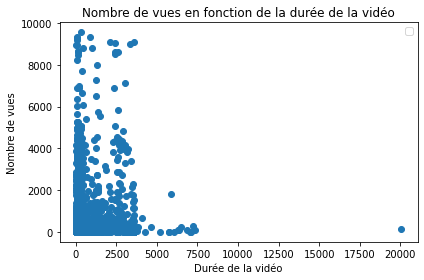

In [30]:
fig, ax = plt.subplots()
ax.scatter(metadata['duration'], metadata['views'])
ax.set_title('Nombre de vues en fonction de la durée de la vidéo')


plt.legend()
plt.xlabel('Durée de la vidéo')
plt.ylabel('Nombre de vues')
plt.tight_layout()
plt.show()

La plupart des vidéos durent entre 0 et 3500s (soit 58 minutes). Sur cette plage de durée, aucune relation claire n'est visible entre le nombre de vues et la durée de la vidéo. Cependant, si l'on dépasse 58 minutes, le nombre de vues baisse fortement. On peut tout de même remarquer que les vidéos courtes semblent obtenir plus de vues que les autres.

Nous allons maintenant regarder l'influence de la langue.

No handles with labels found to put in legend.


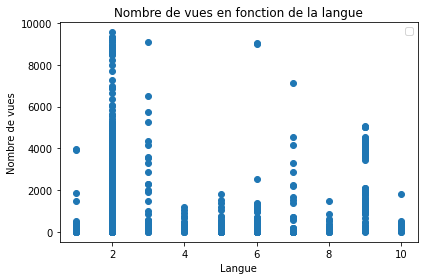

In [32]:
fig, ax = plt.subplots()
ax.scatter(metadata['language'], metadata['views'])
ax.set_title('Nombre de vues en fonction de la langue')


plt.legend()
plt.xlabel('Langue')
plt.ylabel('Nombre de vues')
plt.tight_layout()
plt.show()

La langue influence grandement le nombre de vues ce qui paraît normal car une langue plus universelle telle que l'anglais est comprise par plus de personnes et donc vue aussi par plus de personnes. Ainsi les vidéos de la langue 2, pour lesquelles les nombres de vues sont plus conséquents, sont sûrement comprises par plus de personnes. N'ayant pas la correspondance des entiers avec les langues, nous ne pouvons pas vérifier la nature des langues. 

Examinons le nombre de likes

No handles with labels found to put in legend.


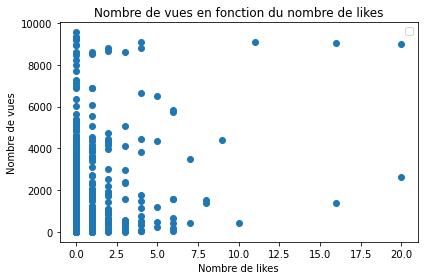

In [33]:
fig, ax = plt.subplots()
ax.scatter(metadata['n_likes'], metadata['views'])
ax.set_title('Nombre de vues en fonction du nombre de likes')


plt.legend()
plt.xlabel('Nombre de likes')
plt.ylabel('Nombre de vues')
plt.tight_layout()
plt.show()

Ce graphique ne nous permet pas de tirer des conclusion sur l'influence du nombre de likes sur le nombre de vues.

Influence du nombre de tags :

No handles with labels found to put in legend.


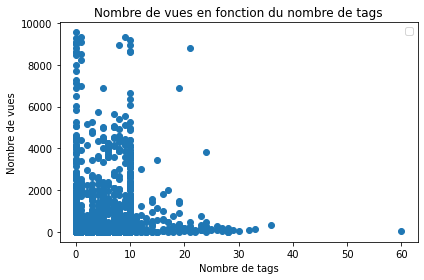

In [35]:
fig, ax = plt.subplots()
ax.scatter(metadata['n_tags'], metadata['views'])
ax.set_title('Nombre de vues en fonction du nombre de tags')


plt.legend()
plt.xlabel('Nombre de tags')
plt.ylabel('Nombre de vues')
plt.tight_layout()
plt.show()
plt.hist(metadata['hour'], bins = 24)
plt.xlabel('Heure')
plt.ylabel('Nombre de vues')
plt.title('Nombre de vues en fonction de lheure de publication')

Comme pour le graphique précédent, le nombre de tags ne semblent pas influencer le nombre de vues.

Nous allons maintenant nous intéresser à l'heure à laquelle la vidéo a été postée.

No handles with labels found to put in legend.


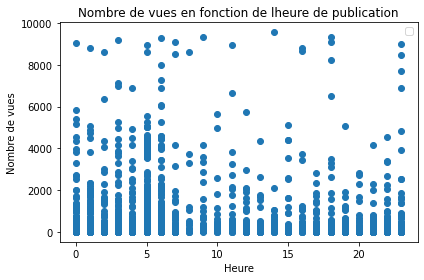

In [44]:
fig, ax = plt.subplots()
ax.scatter(metadata['hour'], metadata['views'])
ax.set_title('Nombre de vues en fonction de lheure de publication')

plt.legend()
plt.xlabel('Heure')
plt.ylabel('Nombre de vues')
plt.tight_layout()
plt.show()

Il semble que plus la vidéo est postée tôt plus elle est suceptible d'avoir un nombre de vues élevé avec une augmentation à 5h. Cependant une vidéo peut être diffusées partout dans le monde et donc pas sur le même fuseau horaire qu'une autre. Sans plus d'informations sur cette mesure, il est difficile de s'avancer plus loin dans cette hypothèse. 

Pour finir nous allons nous concentrer sur le jour à laquelle la vidéo a été publiée.

No handles with labels found to put in legend.


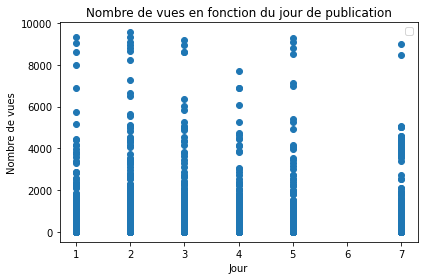

In [46]:
fig, ax = plt.subplots()
ax.scatter(metadata['duration'], metadata['views'])
ax.set_title('Nombre de vues en fonction du jour de publication')


plt.legend()
plt.xlabel('Jour')
plt.ylabel('Nombre de vues')
plt.tight_layout()
plt.show()

Etonnement, on peut remarquer qu'aucune vidéo ne semble être postée le jour 6 (que l'on suppose être le samedi).

Nous allons maintenant nous intéresser à la distribution des données.

Text(0.5, 1.0, 'Nombre de vidéos en fonction de leur durée')

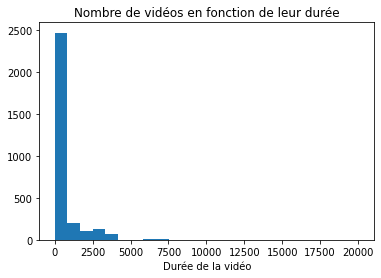

In [52]:
plt.hist(metadata['duration'], bins = 24)
plt.xlabel('Durée de la vidéo')
plt.title('Nombre de vidéos en fonction de leur durée')

On remarque que la distribution de la variable 'duration' (durée de la vidéo) n'est pas normale. On peut aussi voir que la plupart des vidéos sont des vidéos courtes.

Text(0.5, 1.0, 'Nombre de vidéos en fonction de la langue')

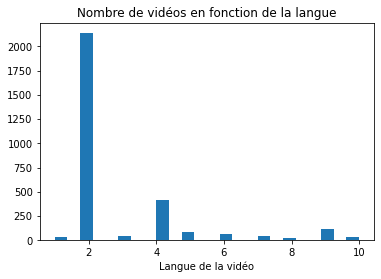

In [50]:
plt.hist(metadata['language'], bins = 24)
plt.xlabel('Langue de la vidéo')
plt.title('Nombre de vidéos en fonction de la langue')

La distribution n'est pas normale. On peut remarquer que la majorité des vidéos sont dans la langue 2 (comme vue précédemment).

Text(0.5, 1.0, 'Nombre de vidéos en fonction du nombre de likes')

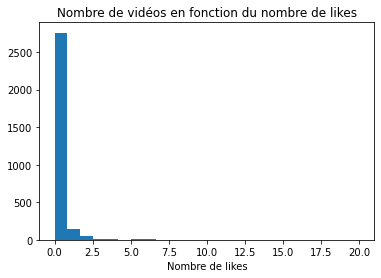

In [51]:
plt.hist(metadata['n_likes'], bins = 24)
plt.xlabel('Nombre de likes')
plt.title('Nombre de vidéos en fonction du nombre de likes')

La distribution n'est pas normale. Comme on a pu le voir avec la commamde describe(), les vidéos n'ont pas un grand nombre de likes.

Text(0.5, 1.0, 'Nombre de vidéos en fonction du nombre de tags')

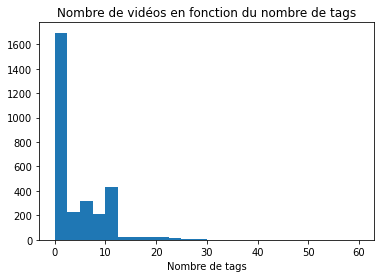

In [53]:
plt.hist(metadata['n_tags'], bins = 24)
plt.xlabel('Nombre de tags')
plt.title('Nombre de vidéos en fonction du nombre de tags')

La distribution n'est pas normale. Comme pour le nombre de likes, les vidéos ont en majorité peu de tags.

Text(0.5, 1.0, 'Nombre de vidéos publiées en fonction de lheure')

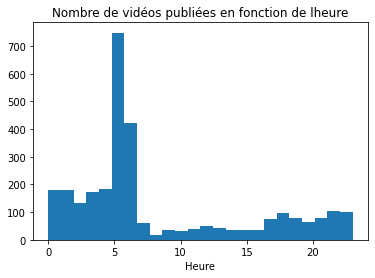

In [48]:
plt.hist(metadata['hour'], bins = 24)
plt.xlabel('Heure')
plt.title('Nombre de vidéos publiées en fonction de lheure')

Il semble que la majeur partie des vidéos soient postées tôt avec un maximum à 5h et une période plus creuse entre 8h et 16h.  

Text(0.5, 1.0, 'Nombre de vidéos publiées en fonction du jour')

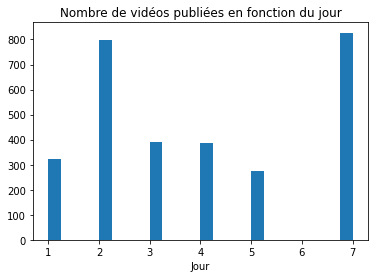

In [49]:
plt.hist(metadata['dayofweek'], bins = 24)
plt.xlabel('Jour')
plt.title('Nombre de vidéos publiées en fonction du jour')

En plus de la remarque précédente, les vidéos sont majoriatirement postées le jour 2 et le jour 7.  

Avant de passer au traitement des données, on va étudier la corrélation entre le nombre de vues et les différentes variables.

In [54]:
corré = metadata[['views','dayofweek' , 'duration', 'language', 'n_likes', 'n_tags','n_formats', 'hour','ratio']]
s_values = corré.corr().sort_values('views', ascending=False).index
corré.corr()[s_values].iloc[0]

views        1.000000
n_likes      0.288940
language     0.105701
ratio        0.102332
n_tags       0.081795
duration     0.073680
n_formats    0.034488
hour        -0.014262
dayofweek   -0.022092
Name: views, dtype: float64

La corrélation permet de nous confirmer l'influence de la langue sur le nombre de vues. Cependant, contrairement à ce que l'on pouvait penser, la variable qui a le plus d'influence sur le nombre de vues est le nombre de likes. 

Les variables caractérisant l'heure et le jour de publication de la vidéo n'ont pas beaucoup d'influence sur le nombre de vues. En effet une fois postée, la vidéo reste en ligne et elle peut donc être vue à tout moment de la semaine. 

In [55]:
# Concaténation:

concat_avec_id = pd.concat([metadata,image,title,description], axis = 1)
corrs = concat_avec_id.corr('pearson')['views'].sort_values(ascending = False)

corrs_abs = corrs.abs()
print(corrs_abs.head(21))

views         1.000000
n_likes       0.288940
desc_16       0.114282
desc_46       0.113965
language      0.105701
ratio         0.102332
title_8       0.084805
n_tags        0.081795
desc_24       0.080158
duration      0.073680
title_27      0.072551
image_217     0.066003
image_1531    0.058625
image_1714    0.057708
image_1404    0.057267
image_3012    0.055745
image_630     0.055562
desc_20       0.054243
image_1223    0.053953
image_487     0.053856
image_1557    0.053534
Name: views, dtype: float64


## Préprocessing

Après une analyse des données, nous allons passé au pré-traitement afin de pouvoir appliquer nos modèles.

Dans un premier temps, nous allons changé les variables booléennes du premier jeu de données (voir téléchargement et premières analyses) en données catégorielles.

On va utiliser One hot encoding.

In [57]:
embed = pd.get_dummies(metadata.embed, prefix ='emb')
partner = pd.get_dummies(metadata.partner, prefix ='prt')
partner_active = pd.get_dummies(metadata.partner_active, prefix ='prt_a')
language = pd.get_dummies(metadata['language'], prefix='lng')

La différence de temps entre les vidéos publiées à 10h et 11h est bien sûr de 1 heure. Si nous laissons la caractéristique de l'heure non encodée, tout fonctionne dans ce cas : 23 - 22 = 1 

Cependant, si nous examinons les lignes 23h et 00h , nous constatons l'échec de notre encodage :  0 - 23 = -23 , même si les vidéos ne sont séparés que d'une heure.

Nous devons modifier l'encodage de la variable cyclique heure et la variable dayofweek de manière à ce que minuit et 23h00 soient à la même distance l'un de l'autre que n'importe quelle autre heure.

**Encoding des variables cycliques:**
    
Une méthode courante d'encodage des données cycliques consiste à transformer les données en deux dimensions à l'aide d'une transformation en sin et en cos.

In [59]:
sin_hour = np.sin(2*np.pi*metadata['hour']/24.0)
sin_hour.name = 'sin_hour'
cos_hour = np.cos(2*np.pi*metadata['hour']/24.0)
cos_hour.name = 'cos_hour'
sin_day = np.sin(2*np.pi*metadata['dayofweek']/7.0)
sin_day.name = 'sin_day'
cos_day = np.cos(2*np.pi*metadata['dayofweek']/7.0)
cos_day.name = 'cos_day'

On applique les transformations précédentes:

In [87]:
metadata_new = pd.concat([metadata[['comp_id', 'views', 'ratio', 'n_likes','n_tags', 'duration']].reset_index(drop=True),
                           embed, partner, partner_active, language, sin_hour, cos_hour, cos_day, sin_day], axis=1)
metadata_new.head()

,comp_id,views,ratio,n_likes,n_tags,duration,emb_False,emb_True,prt_False,prt_True,prt_a_False,prt_a_True,lng_1,lng_2,lng_3,lng_4,lng_5,lng_6,lng_7,lng_8,lng_9,lng_10,sin_hour,cos_hour,cos_day,sin_day
0,1,290,1.77778,0,3,86,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1.0,6.123234e-17,-0.222521,-0.974928
1,2,1443,1.33333,0,0,1129,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1.0,6.123234e-17,-0.222521,-0.974928
2,3,329,1.76667,0,0,1163,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1.0,6.123234e-17,-0.222521,-0.974928
3,4,63,1.77778,0,0,1326,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1.0,6.123234e-17,-0.222521,-0.974928
4,5,37,1.77273,3,0,2612,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1.0,6.123234e-17,-0.222521,-0.974928


Nous allons maitenant passer à nos données Image:

Ce jeu de données comportent 4 000 colonnes, ce qui peut ralentir considérablement nos modèles. Pour éviter cela, nous allons utiliser la régression lasso.

L'idée principale du lasso est d'obtenir plusieurs prédicteurs qui minimisent l'erreur de prédiction pour une variable cible "Views" en imposant une contrainte sur les paramètres du modèle qui fait que certaines variables se réduisent à zéro. Cette dernière partie est importante car elle nous permet de réduire les dimensions de nos données d'image.

In [88]:
y = metadata['views']
x = image.loc[:, image.columns != 'comp_id']

In [66]:
model = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))

model.fit(x, y)
model_index = model.get_support()

count = collections.Counter(model.get_support())
count

Counter({False: 2742, True: 1258})

La régularisation consiste à appliquer une pénalité pour augmenter l'amplitude des valeurs des paramètres afin de réduire l'overfitting. Lorsqu'on entraîne un modèle tel qu'un modèle de régression logistique, on choisit les paramètres qui donnent le meilleur ajustement aux données. Cela signifie qu'il faut minimiser l'erreur entre la prédiction et la réalité terrain.

Le problème se pose lorsqu'on a beaucoup de paramètres (beaucoup de variables indépendantes) mais peu de données. Dans ce cas, le modèle adaptera souvent les valeurs des paramètres aux idiosyncrasies des données - ce qui signifie qu'il s'adapte presque parfaitement aux données de l'entrainement. Cependant, comme ces idiosyncrasies n'apparaissent pas dans les données test, le modèle n'effectue pas une prédiction correcte.

Pour résoudre ce problème, en plus de minimiser l'erreur comme nous l'avons déjà vu, on a ajouté le paramètre C=1 qui inverse la force de régularisation, des valeurs plus petites indiquent une régularisation plus forte.

**Il nous reste un total de 1 258 colonnes.**

Nous allons laissé seulement les 1258 colonnes les plus importants de notre jeu de donnée Image.

In [89]:
image_idx = pd.DataFrame(x[x.columns[(model_index)]])
image_new = pd.concat([image[['comp_id']], image_idx], axis=1)
image_new.head()

,comp_id,image_1,image_3,image_4,image_11,image_15,image_17,image_20,image_24,image_26,image_29,image_33,image_38,image_41,image_42,image_45,image_48,image_52,image_70,image_71,image_72,image_77,image_80,image_82,image_85,image_87,image_92,image_94,image_95,image_96,image_98,image_101,image_110,image_118,image_119,image_124,image_129,image_135,image_142,image_145,...,image_3842,image_3844,image_3845,image_3848,image_3849,image_3851,image_3856,image_3862,image_3868,image_3880,image_3889,image_3890,image_3892,image_3894,image_3897,image_3899,image_3904,image_3907,image_3910,image_3916,image_3924,image_3926,image_3929,image_3932,image_3943,image_3944,image_3946,image_3947,image_3957,image_3958,image_3959,image_3960,image_3962,image_3966,image_3968,image_3973,image_3974,image_3977,image_3984,image_3990
0,1,0.484456,-0.149328,0.144475,0.780332,-1.193367,0.359643,0.201758,0.392215,0.049990,1.561772,1.398923,-0.469053,-0.201135,0.654774,-0.010272,-2.294257,0.213377,0.363581,-0.685833,0.111829,0.674146,0.942569,0.969569,1.158182,0.195791,-0.969695,-0.477639,-0.366914,-1.913973,-0.338678,-0.023543,-1.129131,0.143965,0.677368,0.283335,-0.498193,0.270579,-0.616901,1.041734,...,-0.688167,-1.641789,-0.711524,-0.916584,0.634678,0.254656,0.295851,-0.002767,0.652335,-0.655231,-6.070977,-0.755872,1.559476,1.452236,0.453110,-0.806334,-2.051662,0.027525,1.175223,-0.257737,-1.097092,-0.375472,-0.310596,-1.836144,-7.671426,4.883176,1.104062,0.755437,-1.418211,0.571643,-0.506946,-0.162883,-1.364837,-0.781976,-3.690247,1.522198,-0.606094,0.658431,-0.604360,0.111028
1,2,0.074533,-0.016286,-0.480964,0.410953,0.797866,-0.103046,-0.820352,-0.237525,-0.127445,0.092049,-0.173552,-0.769628,-0.157064,-0.936632,-0.688076,-0.290775,-0.132548,1.046307,-0.152651,-3.680610,-1.277761,-0.318260,0.846168,0.580758,-0.061647,-0.162859,-0.044717,-0.623375,0.088911,0.658993,0.470742,-0.274444,-0.649374,0.249240,-0.888138,0.003847,-0.312809,-1.502790,0.103435,...,0.427027,0.016776,0.060192,0.054140,1.188652,-1.135208,0.213167,0.286731,-0.022780,-1.274276,-2.541646,-0.019520,-0.034465,0.126218,-0.679646,-0.719898,-0.798027,0.288983,0.795949,0.676574,0.198020,0.380690,-1.350619,-0.624966,-2.278313,-0.468203,0.066688,0.640690,-1.703507,0.103802,1.284343,0.019412,0.406546,-0.552040,0.225877,1.708743,-0.204869,-0.510086,0.410483,-0.102448
2,3,-0.396809,-1.723037,0.666147,-0.006978,-1.849174,-0.451063,-0.669081,0.824120,0.288842,-1.261856,-0.056531,-0.634231,-0.084242,-1.114264,-0.298926,-3.862903,-0.428824,1.242752,1.301610,1.750511,1.105347,-1.283686,0.756559,-0.023867,-0.028867,-0.873462,0.450887,-0.183318,0.161405,-0.540422,1.064937,-0.858482,0.613253,-0.063294,0.069435,0.253167,0.167378,-1.982087,-1.047908,...,0.561813,-1.538254,-1.140233,-1.490336,-1.057393,-0.709770,0.127387,-0.197847,-1.031728,-1.601098,-12.186877,-0.974039,0.493728,1.894651,0.715750,0.588887,-1.315847,-0.515519,-0.782052,-0.009799,0.318188,-0.651851,0.855341,-2.795952,0.263273,0.881765,-1.237637,-0.549863,0.819358,-1.341328,-0.249109,-0.389832,1.867043,1.650881,2.086596,-1.253300,-0.229919,-0.377193,0.605521,-0.384109
3,4,0.995316,0.387472,-0.684791,-0.356708,0.807046,0.111972,0.294054,5.531464,0.550411,-0.647365,-0.379089,0.101765,-1.159466,-0.041758,0.125642,-3.310392,-0.969488,2.218117,-0.137710,0.491617,0.312859,-0.837037,0.592292,-0.102958,0.175682,-0.490302,1.144010,0.095253,-0.355241,-1.071852,0.707317,-0.946907,-0.307078,-0.699664,-0.374121,-0.456004,0.831626,-0.362749,-1.570100,...,-0.010726,-0.972188,-0.498447,-0.833010,-0.043913,0.268160,-0.118007,0.461594,-0.793570,-0.413192,-1.251479,0.456172,-0.045441,1.432179,0.436345,-0.341799,0.597015,-0.794545,0.671484,0.701167,0.066750,0.866278,-1.337706,0.618288,0.385956,-0.200553,-0.148386,0.870408,-1.743515,0.721996,1.032519,-0.087203,-1.364425,-0.414214,-2.780271,-0.199446,-0.387944,1.334685,0.869679,0.302376
4,5,-0.611648,-0.572393,0.894287,-0.260793,-0.219198,1.063709,0.717563,1.603678,-0.398335,0.292458,0.996249,0.843059,-1.151790,0.423280,-

Maintenant que nous avons effectué les transformations nécessaires sur nos données, il est temps de fusionner tous les ensembles de données séparés en un seul afin de l'utiliser pour nos modèles.

In [90]:
# Concaténation:
concat_avec_id = pd.concat([metadata_new,image_new,title,description], axis = 1)
#On enlève l'id de chaque vidéo pour entraîner et tester nos modèles
concat = concat_avec_id.drop(['comp_id'],axis = 1)
concat.head()

,views,ratio,n_likes,n_tags,duration,emb_False,emb_True,prt_False,prt_True,prt_a_False,prt_a_True,lng_1,lng_2,lng_3,lng_4,lng_5,lng_6,lng_7,lng_8,lng_9,lng_10,sin_hour,cos_hour,cos_day,sin_day,image_1,image_3,image_4,image_11,image_15,image_17,image_20,image_24,image_26,image_29,image_33,image_38,image_41,image_42,image_45,...,desc_11,desc_12,desc_13,desc_14,desc_15,desc_16,desc_17,desc_18,desc_19,desc_20,desc_21,desc_22,desc_23,desc_24,desc_25,desc_26,desc_27,desc_28,desc_29,desc_30,desc_31,desc_32,desc_33,desc_34,desc_35,desc_36,desc_37,desc_38,desc_39,desc_40,desc_41,desc_42,desc_43,desc_44,desc_45,desc_46,desc_47,desc_48,desc_49,desc_50
0,290,1.77778,0,3,86,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1.0,6.123234e-17,-0.222521,-0.974928,0.484456,-0.149328,0.144475,0.780332,-1.193367,0.359643,0.201758,0.392215,0.049990,1.561772,1.398923,-0.469053,-0.201135,0.654774,-0.010272,...,0.028440,-0.085249,0.007856,-0.000305,0.008731,-0.068400,0.003454,0.001329,0.013231,-0.007687,0.030407,-0.001134,0.000494,-6.461385,0.038131,0.026232,-0.001567,0.009113,0.016394,-0.005538,-0.009708,-0.013093,-0.005617,0.006824,0.012795,-0.021388,-0.105503,0.006901,0.000284,0.027454,-0.029430,-0.029423,0.052256,0.007814,0.023472,-0.021134,0.003324,-0.004393,0.004294,-0.002223
1,1443,1.33333,0,0,1129,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1.0,6.123234e-17,-0.222521,-0.974928,0.074533,-0.016286,-0.480964,0.410953,0.797866,-0.103046,-0.820352,-0.237525,-0.127445,0.092049,-0.173552,-0.769628,-0.157064,-0.936632,-0.688076,...,0.028440,-0.085249,0.007856,-0.000305,0.008731,-0.068400,0.003454,0.001329,0.013231,-0.007687,0.030407,-0.001134,0.000494,-6.461385,0.038131,0.026232,-0.001567,0.009113,0.016394,-0.005538,-0.009708,-0.013093,-0.005617,0.006824,0.012795,-0.021388,-0.105503,0.006901,0.000284,0.027454,-0.029430,-0.029423,0.052256,0.007814,0.023472,-0.021134,0.003324,-0.004393,0.004294,-0.002223
2,329,1.76667,0,0,1163,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1.0,6.123234e-17,-0.222521,-0.974928,-0.396809,-1.723037,0.666147,-0.006978,-1.849174,-0.451063,-0.669081,0.824120,0.288842,-1.261856,-0.056531,-0.634231,-0.084242,-1.114264,-0.298926,...,-0.175824,2.032145,-0.143330,-0.394972,-0.157462,0.245942,0.405734,0.010298,-0.601022,-0.022109,0.284740,0.170112,-0.057594,3.057399,-0.146002,0.143649,0.914032,-0.035008,-0.156502,0.083768,0.597216,0.656176,-0.071332,0.730609,0.038204,-0.837585,-0.977806,0.663729,0.014156,0.530039,-0.626436,-0.102908,0.576792,-0.805986,0.310637,0.422263,0.403496,0.264240,7.057590,-0.252417
3,63,1.77778,0,0,1326,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1.0,6.123234e-17,-0.222521,-0.974928,0.995316,0.387472,-0.684791,-0.356708,0.807046,0.111972,0.294054,5.531464,0.550411,-0.647365,-0.379089,0.101765,-1.159466,-0.041758,0.125642,...,-0.051879,2.339253,-0.136640,-0.248848,-0.404962,0.199895,0.182226,0.033816,-0.706218,0.130868,0.501670,0.186079,-0.162675,3.070982,-0.032498,0.068264,1.034647,0.028793,-0.244596,0.037327,0.607908,0.415434,0.059239,0.319092,0.092515,-0.831052,-0.817347,0.602119,-0.067764,0.176569,-0.435836,0.052975,0.108777,-0.599593,0.408430,0.591615,0.415667,0.334706,7.025648,-0.309093
4,37,1.77273,3,0,2612,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1.0,6.123234e-17,-0.222521,-0.974928,-0.611648,-0.572393,0.894287,-0.260793,-0.219198,1.063709,0.717563,1.603678,-0.398335,0.292458,0.996249,0.843059,-1.151790,0.423280,-0.128635,...,-0.529120,1.597859,1.062390,0.169534,-0.207715,-1.352804,0.181599,0.210282,0.515549,-0.411344,0.509503,0.897175,-0.348758,2.843993,-0.599135,0.031930,-0.849955,0.012406,0.019594,-0.332295,0.389301,-0.292774,0.386677,-3.005544,0.383045,-0.167495,-0.326522,0.134930,0.089576,0.669632,-1.714496,0.297421,-0.097744,0.000669,-1.639307,0.244313,0.099975,0.371806,-2.259024,-0.131085


Séparation du jeu de données en train et test pour évaluer nos modèles avant de faire une prédiction sur les données de test. 

In [91]:
y_concat = concat['views']
X_concat = concat.drop(['views'], axis = 1)

# On sépare avec 80% du jeu de données pour l'entraînement et 20% pour le test
X_concat_train, X_concat_test, y_concat_train, y_concat_test = train_test_split(X_concat, y_concat, test_size=0.2)

Dans ce notebook, nous nous sommes concentrés sur les quatre jeux de données d'entraînement pour construire nos modèles. En effet le jeu de test ne contient pas le nombre de vues et ne nous permet donc pas d'évaluer nos modèles. Il est uniquement utilisé pour les soumissions.

## Premiers modèles

Nous allons tout d'abord créer une fonction pour la métrique utilisée lors de l'évaluation du challenge. 

In [72]:
def evaluation(y_test,y_predict):
  rmse = sqrt(mean_squared_error(y_test,y_predict))
  error = exp(-rmse/y_test.max())
  return error

### **Régression linéaire**

Pour notre premier modèle, nous allons effectuer une regression linéaire sur notre jeu de donnée concaténé. 

Pour ce faire, nous allons d'abord mettre à l'échelle nos données:

In [73]:
std_scale = preprocessing.StandardScaler().fit(X_concat_train)
X_train_std = std_scale.transform(X_concat_train)
X_test_std = std_scale.transform(X_concat_test)

In [79]:
# Entraînement
linearReg = LinearRegression().fit(X_train_std,y_concat_train)

# Test et évaluation
y_pred_linearReg = linearReg.predict(X_test_std)
print(evaluation(y_concat_test,y_pred_linearReg))

0.8150072853099513


Avec un simple modèle linéaire nous obtenons un score de 0.815, ce qui est assez faible. Nous allons donc maintenant tester une regression non-linéaire avec SVR.

### **SVR**

In [77]:
for k in ['linear','poly','rbf','sigmoid']: 
    svr = svm.SVR(kernel=k)
    svr.fit(X_train_std, y_concat_train)
    y_pred_svr = svr.predict(X_test_std)
    print(evaluation(y_concat_test,y_pred_svr))

0.8682720826389111
0.8610071312343667
0.8609954247080754
0.8610273368360938


Pour cette méthode, le paramètre le plus optimal semble être un noyau linéaire. De plus, on peut voir une nette amélioration du score avec maintenant un modèle à 0.0868.

### **Arbre de décision**

Nous allons maintenant passer aux méthodes arbre de décision et forêt aléatoire. Pour ces méthodes nous n'avons pas besoin de mettre à l'échelle nos données.

In [80]:
# Entraînement
model_tree = tree.DecisionTreeRegressor()
model_tree.fit(X_concat_train, y_concat_train)

# Test et évaluation
y_pred_tree = model_tree.predict(X_concat_test)
print(evaluation(y_concat_test,y_pred_tree))

0.8446131273380897


Cette méthode est moins satisfaisante que SVR. En effet on obtient un score de 0.844.

### **Forêt aléatoire**

In [81]:
# Entraînement
model_rf = RandomForestRegressor()
model_rf.fit(X_concat_train, y_concat_train)

# Test et évaluation
y_pred_rf= model_rf.predict(X_concat_test)
print(evaluation(y_concat_test,y_pred_rf))

0.8776789435673219


Nous obtenons un meilleur score que les précédentes méthodes : 0.877. Nous allons donc essayer d'optimiser cette dernière.

Nous allons essayer de trouver les meilleurs paramètres pour notre modèle de forêt aléatoire grâce à une GridSearch. Nous allons essayer de minimiser le score ("neg_mean_squared_error") comme c'est aussi pour la métrique d'évaluation du challenge et nous allons utiliser une validation croisée.

Pour faire cette recherche, nous avons utilisé uniquement les paramètres ayant la plus grande corrélation avec le nombre de vues. Nous avons gardé ceux avec une corrélation supérieure à 0.06 (voir précédemment). Nous avons pris cette décision car le temps de calcul avec le jeu de données complet était très long.

Ayant appliquer toutes nos recherches d'optimisation des paramètres sur des notebooks séparés pour chaque méthode et pas toujours avec le même préprocessing, nous n'avons pas eu le temps de lancer de nouveau ces recherches qui sont assez longues. Nous laissons tout de même le code utilisé avec les résultats obtenus (dans le modèle suivant) en piste d'amélioration à ce notebook.

In [97]:
X_gridsearch = pd.concat([X_concat_train['n_likes'],X_concat_train['desc_16'],X_concat_train['desc_46'],X_concat_train['lng_1'],X_concat_train['lng_2'],X_concat_train['lng_3'],X_concat_train['lng_4'],X_concat_train['lng_5'],X_concat_train['lng_6'],X_concat_train['lng_7'],X_concat_train['lng_8'],X_concat_train['lng_9'],X_concat_train['ratio'],X_concat_train['title_8'],X_concat_train['n_tags'],X_concat_train['desc_24'],X_concat_train['duration'],X_concat_train['title_27'],X_concat_train['image_217']], axis = 1)

In [98]:
X_gridsearch.head()

,n_likes,desc_16,desc_46,lng_1,lng_2,lng_3,lng_4,lng_5,lng_6,lng_7,lng_8,lng_9,ratio,title_8,n_tags,desc_24,duration,title_27,image_217
1985,0,-0.580995,0.129258,0,1,0,0,0,0,0,0,0,1.77778,0.085759,8,4.591681,279,0.692352,5.066569
650,0,-0.068400,-0.021134,0,0,0,1,0,0,0,0,0,2.35294,-0.112628,0,-6.461385,16,-2.145566,5.938908
1011,0,-0.068400,-0.021134,0,1,0,0,0,0,0,0,0,1.77778,-0.401823,0,-6.461385,13,-0.434730,-1.110890
2133,0,-0.068400,-0.021134,0,1,0,0,0,0,0,0,0,1.77778,-0.108839,0,-6.461385,124,0.886919,1.081518
2438,0,-1.140755,-1.686569,0,1,0,0,0,0,0,0,0,1.33333,-0.292554,0,3.355752,73,0.081625,-2.758764


In [ ]:
# Déclaration du modèle
rf = RandomForestRegressor()

#Définition de la grille de recherche
grid_values = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 2000, num = 40)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(27, 40, num = 1)],
               'min_samples_split': [2, 5, 10, 15, 20, 25, 30, 35, 40, 100],
               'min_samples_leaf': [ 10, 15, 20, 50]}

# Recherche des meilleurs paramètres en fonction des données d'entraînement
grid_rf = GridSearchCV(rf, param_grid = grid_values, scoring = 'neg_mean_squared_error', cv=5,n_jobs = -1)
grid_rf.fit(X_gridsearch, y_concat_train)

# Affichage des meilleurs paramètres
print('Meilleurs paramètres: ', grid_rf.best_params_)

Nouveau modèle avec les paramètres optimaux trouvés:

In [82]:
# Entraînement
model_rf_tuned = RandomForestRegressor(n_estimators=1807,min_samples_split=22, min_samples_leaf=10, max_features='sqrt',max_depth=27)
model_rf_tuned.fit(X_concat_train, y_concat_train)

# Test et évaluation
y_pred_rf_tuned= model_rf_tuned.predict(X_concat_test)
print(evaluation(y_concat_test,y_pred_rf_tuned))

0.8740274073049136


On peut constater que le préprocessing des données influence grandement les modèles. En effet, les meilleurs paramètres obtenus pour un préprocessing des données différent ne sont pas applicables avec ce préprocessing. Ils nous donnent un moins bon résultat que sans optimisation.

## Autres modèles

Après les méthodes "classiques", nous allons tester des modèles qui sont réputés pour être plus performant dans l'espoir d'obtenir de meilleurs résultats.

### **Lasso**

Le premier de ces modèles est lasso.

In [100]:
# Entraînement
model_concat_lasso = Lasso(alpha = 100, max_iter = 30, tol = 0.1)
model_concat_lasso.fit(X_concat_train, y_concat_train)

# Test et évaluation
y_pred = model_concat_lasso.predict(X_concat_test)
print(evaluation(y_concat_test,y_pred))

0.8766135170259098


Avec Lasso nous obtenons un score de 0.876. 

In [ ]:
# Déclaration du modèle
las = Lasso()

# Définition de la grille de recherche
grid_values = {'alpha': [8,9,7], #0.0001,0.0002,0.0004,0.0006,0.0008,0.001, 0.01,0.05,0.1,0.5, 1.0,5.1,10,15,25,30,35,30,40,50,60,70,80,100
               'max_iter':[1],
               'tol':[0.001]} 

# Recherche des meilleurs paramètres en fonction des données d'entraînement
grid_las_mse = GridSearchCV(las, param_grid = grid_values, scoring = 'neg_mean_squared_error', cv=5,n_jobs = -1)
grid_las_mse.fit(X_gridsearch, y_concat_train)

# Affichage des meilleurs paramètres
print('Meilleurs paramètres: : ', grid_las_mse.best_params_)

In [ ]:
las = Lasso( alpha = 7, max_iter = 1, tol = 0.001,  random_state = 0).fit(X_concat_train,y_concat_train)

y_pred_lasso_tuned = las.predict(X_concat_test)

print(evaluation(y_concat_test,y_pred_lasso_tuned))

### **Ridge**

In [104]:
# Entraînement
model_concat_ridge = Ridge(alpha = 50, max_iter = 100, tol = 0.1)
model_concat_ridge.fit(X_concat_train, y_concat_train)

# Test et évaluation
y_pred = model_concat_ridge.predict(X_concat_test)
print(evaluation(y_concat_test,y_pred))

0.8353283037588435


La méthode Ridge ne semble pas adaptée à notre problème avec nos données. En effet avec ce modèle nous n'obtenons un score que de 0,835.

### **XGBoost**

In [105]:
# Entraînement
xgb_model = XGBRegressor()
xgb_model.fit(X_concat_train, y_concat_train)

# Test et évaluation
y_pred_xgb = xgb_model.predict(X_concat_test)
print(evaluation(y_concat_test,y_pred_xgb))

[19:04:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.8768094101211513


XGBoost s'avère un peu plus performant que Lasso mais n'atteint pas encore le score de la forêt aléatoire. (score : 0.8768)

In [ ]:
# Déclaration du modèle
xgb = XGBRegressor()

# Définition de la grille de recherche
grid_values = {'learning_rate': [0.01, 0.1],
               'max_depth': [int(x) for x in np.linspace(5, 40, num = 6)],
               'min_child_weight': [int(x) for x in np.linspace(1, 20, num = 5)],
               'subsample': [0.5, 0.7],
               'colsample_bytree': [0.5, 0.7],
               'objective': ['reg:squarederror'],
               'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 2000, num = 40)]}

# Recherche des meilleurs paramètres en fonction des données d'entraînement
grid_xgb = GridSearchCV(xgb, param_grid = grid_values, scoring = 'neg_mean_squared_error', cv=5,n_jobs = -1)
grid_xgb.fit(X_gridsearch, y_concat_train)

# Affichage des meilleurs paramètres
print('Meilleurs paramètres: ', grid_xgb.best_params_)

In [ ]:
# Entraînement
xgb_model = XGB.XGBRegressor(subsample=0.5, objective='reg:squarederror', n_estimators=1707, min_child_weight=20, max_depth=5, learning_rate=0.01, colsample_bytree=0.5)
xgb_model.fit(X_concat_train, y_concat_train)

# Test et évaluation
y_pred_xgb = xgb_model.predict(X_concat_test)
print(evaluation(y_concat_test, y_pred_xgb))

### **CatBoost**

In [113]:
# Entraînement
model_catboost = CatBoostRegressor()
model_catboost.fit(X_concat_train, y_concat_train)

Learning rate set to 0.045612
0:	learn: 1179.7462735	total: 833ms	remaining: 13m 51s
1:	learn: 1168.2077377	total: 1.24s	remaining: 10m 20s
2:	learn: 1158.6528527	total: 1.65s	remaining: 9m 9s
3:	learn: 1148.9008877	total: 2.06s	remaining: 8m 32s
4:	learn: 1140.6926115	total: 2.48s	remaining: 8m 14s
5:	learn: 1129.9331048	total: 2.89s	remaining: 7m 58s
6:	learn: 1122.8342521	total: 3.31s	remaining: 7m 50s
7:	learn: 1115.7075249	total: 3.74s	remaining: 7m 43s
8:	learn: 1111.3061255	total: 4.15s	remaining: 7m 36s
9:	learn: 1104.0452463	total: 4.57s	remaining: 7m 32s
10:	learn: 1100.0516046	total: 4.97s	remaining: 7m 27s
11:	learn: 1096.8001360	total: 5.44s	remaining: 7m 27s
12:	learn: 1091.3302569	total: 5.87s	remaining: 7m 25s
13:	learn: 1088.8195914	total: 6.28s	remaining: 7m 22s
14:	learn: 1084.5568619	total: 6.7s	remaining: 7m 19s
15:	learn: 1079.2650114	total: 7.11s	remaining: 7m 17s
16:	learn: 1074.4295327	total: 7.52s	remaining: 7m 15s
17:	learn: 1068.6764589	total: 7.96s	remainin

In [107]:
# Test et évaluation
y_pred_catboost = model_catboost.predict(X_concat_test)
print(evaluation(y_concat_test,y_pred_catboost))

0.8806404350492417


Avec CatBoost, le score augmente. Nous passons à 0,880.

### **Lightgbm**

In [108]:
# Entraînement
model_lgbm = LGBMRegressor()
model_lgbm.fit(X_concat_train, y_concat_train)

# Test et évaluation
y_pred = model_lgbm.predict(X_concat_test)
print(evaluation(y_concat_test,y_pred))

0.8785824302244919


Lightgbm est aussi performant pour cette prédiction, il n'égale tout de même pas CatBoost.

In [ ]:
# Déclaration du modèle
lgbm = LGBMRegressor()

# Définition de la grille de recherche
grid_values = {'boosting_type': ['gbdt','dart','goss','rf'], 
               'num_leaves':[1,10,30,50,100],
               'max_depth':[1,10,30,50,100],
               'learning_rate':[0.001,0.01,1],
               'n_estimators':[10,50,100,200,500],
               'subsample_for_bin ':[100000,200000,300000]} 

# Recherche des meilleurs paramètres en fonction des données d'entraînement
grid_lgbm = GridSearchCV(lgbm, param_grid = grid_values, scoring = 'neg_mean_squared_error', cv=5,n_jobs = -1)
grid_lgbm.fit(X_gridsearch, y_concat_train)

# Affichage des meilleurs paramètres
print('Meilleurs paramètres: ', grid_lgbm.best_params_)

In [ ]:
# Entraînement
model_lgbm = LGBMRegressor(num_leaf = 31, learning_rate = 0.05, n_estimator = 20)
model_lgbm.fit(X_concat_train, y_concat_train)

# Test et évaluation
y_pred = model_lgbm.predict(X_concat_test)
print(evaluation(y_concat_test,y_pred))

## Conclusion

A travers ce challenge, nous avons voulu testé des méthodes auxquelles nous n'avions pas encore eu affaire. Tout d'abord, lasso et ridge qui nous ont été présentées lors de la classe inversée puis 3 autres modèles. 

Notre meilleur score avec ce préprocessing et sans effectuer de gridsearch a été obtenu à l'aide du modèle CatBoost qui essaie lui même d'optimiser les paramètres. Cependant avec d'autres modèles tels que la forêt aléatoire, XGBoost, LightGBM, nous avons aussi obtenu de bons scores qui pourraient être optimisés à travers des gridsearch. Ainsi en voie d'amélioration, nous placerons le gridsearch en première place pour optimiser nos modèles. 

Pour revenir au challenge, notre meilleur solution a été obtenue en faisant la moyenne des résultats de Lasso et XGBoost avec un autre préprocessing des données et l'utilisation de gridsearch. 